<a href="https://colab.research.google.com/github/max-dev-eng/ResearchPaperRepository/blob/main/Fig_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

SNAP t=  0.0s | Tmin=600.000000 Tmax=600.000000 spread=0.000000
SNAP t=  20.0s | Tmin=503.592859 Tmax=525.721683 spread=22.128824
Progress:  10.0%
SNAP t=  40.0s | Tmin=433.278299 Tmax=452.870164 spread=19.591865
SNAP t=  60.0s | Tmin=373.604979 Tmax=390.462383 spread=16.857405
Progress:  20.0%
SNAP t=  80.0s | Tmin=322.668280 Tmax=337.095977 spread=14.427697
Progress:  30.0%
SNAP t= 100.0s | Tmin=279.141370 Tmax=291.476692 spread=12.335322
SNAP t= 120.0s | Tmin=241.938359 Tmax=252.482593 spread=10.544234
Progress:  40.0%
SNAP t= 140.0s | Tmin=210.139132 Tmax=219.151982 spread=9.012850
Progress:  50.0%
SNAP t= 160.0s | Tmin=182.958560 Tmax=190.662375 spread=7.703816
SNAP t= 180.0s | Tmin=159.725771 Tmax=166.310668 spread=6.584896
Progress:  60.0%
SNAP t= 200.0s | Tmin=139.867374 Tmax=145.495863 spread=5.628490
Progress:  70.0%
SNAP t= 220.0s | Tmin=122.893260 Tmax=127.704254 spread=4.810994
SNAP t= 240.0s | Tmin=108.384510 Tmax=112.496743 spread=4.112233
Progress:  80.0%
SNAP t= 260.0s

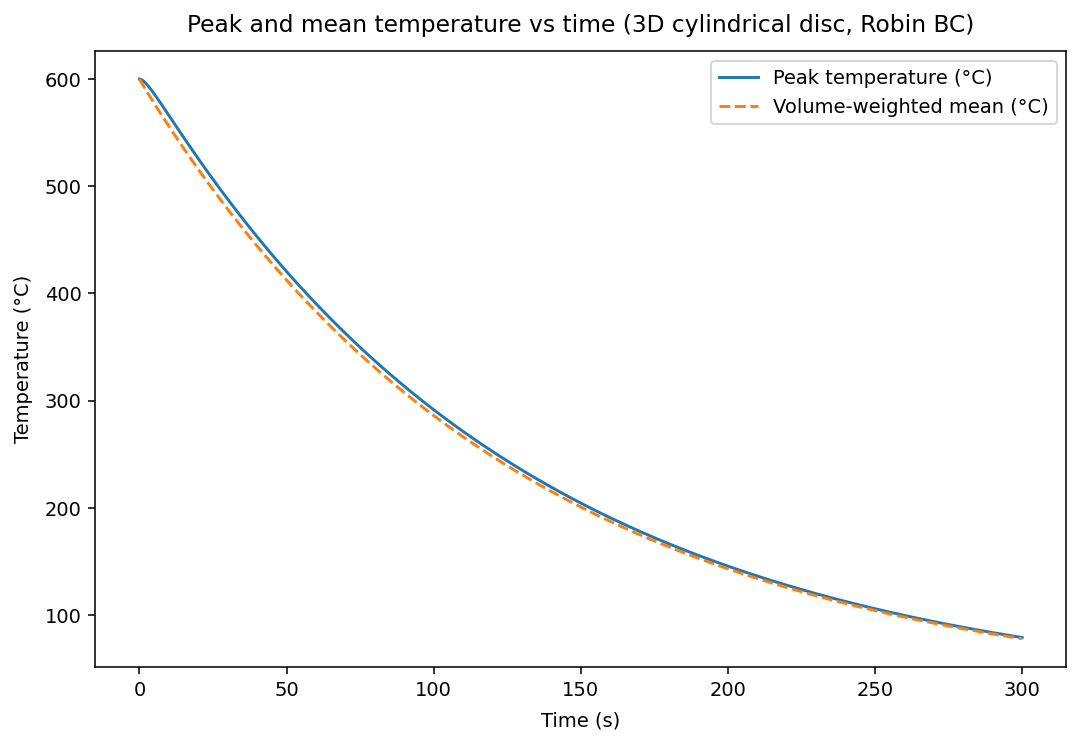


=== FILES CREATED ===
Folder: /content/outputs_disc3D_cylindrical_FIXED
ABS PDF: outputs_disc3D_cylindrical_FIXED/midplanes_absT_0to300_every20s.pdf
ΔT  PDF: outputs_disc3D_cylindrical_FIXED/midplanes_deltaT_0to300_every20s.pdf
Graph : outputs_disc3D_cylindrical_FIXED/peak_mean_vs_time.png
Saved 16 ABS PNGs and 16 ΔT PNGs
TOTAL WALL TIME: 1176.35 s

=== PARAMETERS ===
Ri=0.117 m, Ro=0.195 m, H=0.0357 m
alpha=4.8e-05 m^2/s, k=30.0 W/mK
T0=600.0 °C, T_inf=23.0 °C
h_base=60.0 W/m^2K, h_rim=62.016806722689 W/m^2K
grid: Nr=220, Ntheta=360, Nz=64
time: t_end=300.0 s, dt=0.500000000 s, Nt=600
ABS colour scale: VMIN=76.322168, VMAX=600.000000
Attempting to download PDFs...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Download attempt completed.


In [6]:
import os, math, time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

# -------------------------
# GEOMETRY (SI)
# -------------------------
Do = 0.390
Di = 0.234
H  = 0.0357
Ro = Do / 2.0
Ri = Di / 2.0

# Holes (user)
N_holes = 1000
d_h = 0.003
hole_depth_mm = 0.156
hole_depth = hole_depth_mm * 1e-3

# -------------------------
# THERMAL + BC
# -------------------------
alpha  = 4.8e-5     # m^2/s
k_cond = 30.0       # W/(m K)
h_base = 60.0       # W/(m^2 K)
T_inf  = 23.0       # °C
T0     = 600.0      # °C

# -------------------------
# GRID (detail vs runtime)
# -------------------------
Nr     = 220
Ntheta = 360        # higher => smoother circular images
Nz     = 64

# -------------------------
# TIME
# -------------------------
t_end = 300.0
snapshot_every = 20.0
save_times = np.arange(0.0, t_end + 1e-12, snapshot_every)

dt = 0.5  # smaller => more accurate, slower

# -------------------------
# OUTPUT
# -------------------------
OUTDIR = "outputs_disc3D_cylindrical_FIXED"
os.makedirs(OUTDIR, exist_ok=True)

ABS_PDF = os.path.join(OUTDIR, "midplanes_absT_0to300_every20s.pdf")
DT_PDF  = os.path.join(OUTDIR, "midplanes_deltaT_0to300_every20s.pdf")

FIGSIZE  = (8.4, 7.4)
SAVE_DPI = 500

# NEW (safe defaults to avoid clipping)
SAVE_PAD_INCHES = 0.18
AXIS_MARGIN_FRAC = 0.06  # extra margin around outer radius in x/y limits
TITLE_PAD = 10           # pts
LABEL_PAD = 6            # pts


def effective_h_for_rim_band(h_base: float) -> float:
    """Enhance rim convection based on added internal lateral hole area."""
    A_rim = 2.0 * math.pi * Ro * H
    A_holes = N_holes * (math.pi * d_h * hole_depth)
    return h_base * (A_rim + A_holes) / A_rim


h_rim = float(effective_h_for_rim_band(h_base))

# -------------------------
# Cylindrical grid (cell centers)
# -------------------------
r = np.linspace(Ri, Ro, Nr, dtype=np.float64)
theta = np.linspace(0.0, 2.0*np.pi, Ntheta, endpoint=False, dtype=np.float64)
z = np.linspace(0.0, H, Nz, dtype=np.float64)

dr = float(r[1] - r[0])
dtheta = float(theta[1] - theta[0])
dz = float(z[1] - z[0])

# FFT eigenvalues for periodic θ second derivative
sin2 = (np.sin(np.pi * np.arange(Ntheta, dtype=np.float64) / Ntheta) ** 2)


# -------------------------
# Robin BC constants (first-order one-sided derivative)
# Boundary node Tb with neighbor Tn:
#   Tb - A*Tn = B, where
#   A = (k/d)/(h + k/d),   B = (h*Tinf)/(h + k/d)
# -------------------------
def robin_AB(hcoeff: float, d: float):
    k_over_d = k_cond / d
    A = k_over_d / (hcoeff + k_over_d)
    B = (hcoeff * T_inf) / (hcoeff + k_over_d)
    return float(A), float(B)

A_r_in,  B_r_in  = robin_AB(h_base, dr)  # inner bore
A_r_out, B_r_out = robin_AB(h_rim,  dr)  # outer rim
A_z,     B_z     = robin_AB(h_base, dz)  # both faces


# -------------------------
# Tridiagonal solver (Thomas) for many RHS
# -------------------------
def thomas_batch(a, b, c, d):
    a = np.asarray(a, dtype=np.float64)
    b = np.asarray(b, dtype=np.float64)
    c = np.asarray(c, dtype=np.float64)
    d = np.asarray(d, dtype=np.float64)

    N = b.size
    M = d.shape[0]
    cp = np.empty(N, dtype=np.float64)
    dp = np.empty((M, N), dtype=np.float64)

    denom = b[0]
    if denom == 0.0 or not np.isfinite(denom):
        raise RuntimeError("Tridiagonal: invalid b[0].")

    cp[0] = c[0] / denom
    dp[:, 0] = d[:, 0] / denom

    for i in range(1, N):
        denom = b[i] - a[i] * cp[i-1]
        if denom == 0.0 or not np.isfinite(denom):
            raise RuntimeError(f"Tridiagonal: invalid denom at i={i}.")
        cp[i] = (c[i] / denom) if i < N-1 else 0.0
        dp[:, i] = (d[:, i] - a[i] * dp[:, i-1]) / denom

    x = np.empty((M, N), dtype=np.float64)
    x[:, -1] = dp[:, -1]
    for i in range(N-2, -1, -1):
        x[:, i] = dp[:, i] - cp[i] * x[:, i+1]
    return x


# -------------------------
# θ implicit solve via FFT
# (I - α dt (1/r²) Dθθ) T_new = T_old
# -------------------------
def solve_theta_implicit(T, dt_theta):
    dt_theta = float(dt_theta)
    denom = 1.0 + (alpha * dt_theta) * (4.0 * sin2 / (dtheta*dtheta))[None, :] / (r[:, None] * r[:, None])
    Th = np.fft.fft(T, axis=1)
    Th /= denom[:, :, None]
    return np.fft.ifft(Th, axis=1).real


# -------------------------
# r implicit solve (finite-volume for (1/r) d/dr (r dT/dr))
# BC rows impose Robin directly on T_new
# -------------------------
def solve_r_implicit(T, dt_r):
    dt_r = float(dt_r)
    lam = alpha * dt_r

    a = np.zeros(Nr, dtype=np.float64)
    b = np.zeros(Nr, dtype=np.float64)
    c = np.zeros(Nr, dtype=np.float64)

    # Robin rows:
    b[0] = 1.0
    c[0] = -A_r_in

    a[-1] = -A_r_out
    b[-1] = 1.0

    for i in range(1, Nr-1):
        ri = r[i]
        r_imh = ri - 0.5 * dr
        r_iph = ri + 0.5 * dr
        low = r_imh / (ri * dr*dr)
        up  = r_iph / (ri * dr*dr)
        mid = (r_imh + r_iph) / (ri * dr*dr)

        a[i] = -lam * low
        b[i] = 1.0 + lam * mid
        c[i] = -lam * up

    rhs = np.transpose(T, (1, 2, 0)).reshape(-1, Nr).copy()
    rhs[:, 0]  = B_r_in
    rhs[:, -1] = B_r_out

    sol = thomas_batch(a, b, c, rhs)
    return sol.reshape(Ntheta, Nz, Nr).transpose(2, 0, 1)


# -------------------------
# z implicit solve
# BC rows impose Robin directly on T_new
# -------------------------
def solve_z_implicit(T, dt_z):
    dt_z = float(dt_z)
    lam = alpha * dt_z
    invdz2 = 1.0 / (dz*dz)

    a = np.zeros(Nz, dtype=np.float64)
    b = np.zeros(Nz, dtype=np.float64)
    c = np.zeros(Nz, dtype=np.float64)

    b[0] = 1.0
    c[0] = -A_z
    a[-1] = -A_z
    b[-1] = 1.0

    for k in range(1, Nz-1):
        a[k] = -lam * invdz2
        b[k] = 1.0 + lam * (2.0 * invdz2)
        c[k] = -lam * invdz2

    rhs = T.reshape(-1, Nz).copy()
    rhs[:, 0]  = B_z
    rhs[:, -1] = B_z

    sol = thomas_batch(a, b, c, rhs)
    return sol.reshape(Nr, Ntheta, Nz)


# -------------------------
# Strang splitting step
# -------------------------
def strang_step(T, dt_step):
    half = 0.5 * float(dt_step)
    T = solve_r_implicit(T, half)
    T = solve_theta_implicit(T, half)
    T = solve_z_implicit(T, dt_step)
    T = solve_theta_implicit(T, half)
    T = solve_r_implicit(T, half)
    return T


# -------------------------
# Correct volume-weighted mean
# -------------------------
def peak_and_volume_mean(T):
    peak = float(np.max(T))
    w = r[:, None, None]
    mean = float(np.sum(T * w) / (np.sum(w) * Ntheta * Nz))
    return peak, mean


# -------------------------
# Seam-free, smooth plotting
# -------------------------
theta_closed = np.concatenate([theta, [2.0*np.pi]])
X_plot = r[:, None] * np.cos(theta_closed)[None, :]
Y_plot = r[:, None] * np.sin(theta_closed)[None, :]

def _apply_safe_axes_limits(ax):
    # Ensure nothing clips around the outer circle or tick labels
    margin = AXIS_MARGIN_FRAC * Ro
    lim = Ro + margin
    ax.set_xlim(-lim, lim)
    ax.set_ylim(-lim, lim)
    ax.set_aspect("equal", "box")

def plot_midplane_abs(midplane, t_now, vmin, vmax, pdf=None):
    C = np.concatenate([midplane, midplane[:, :1]], axis=1)

    # Use constrained_layout (best at preventing cutoffs with colorbars)
    fig, ax = plt.subplots(figsize=FIGSIZE, dpi=140, constrained_layout=True)
    qm = ax.pcolormesh(X_plot, Y_plot, C, shading="gouraud", vmin=vmin, vmax=vmax)
    qm.set_rasterized(True)

    ax.add_patch(plt.Circle((0, 0), Ro, fill=False, linewidth=2.2))
    ax.add_patch(plt.Circle((0, 0), Ri, fill=False, linewidth=2.2))
    _apply_safe_axes_limits(ax)

    ax.set_xlabel("x (m)", labelpad=LABEL_PAD)
    ax.set_ylabel("y (m)", labelpad=LABEL_PAD)
    ax.set_title(f"Mid-plane temperature at t = {t_now:.0f} s", pad=TITLE_PAD)

    cb = fig.colorbar(qm, ax=ax, fraction=0.046, pad=0.04)
    cb.set_label("Temperature (°C)", labelpad=LABEL_PAD)

    outpath = os.path.join(OUTDIR, f"midplane_absT_t{int(round(t_now))}s.png")
    fig.savefig(outpath, dpi=SAVE_DPI, bbox_inches="tight", pad_inches=SAVE_PAD_INCHES)
    if pdf is not None:
        pdf.savefig(fig, bbox_inches="tight", pad_inches=SAVE_PAD_INCHES)
    plt.close(fig)
    return outpath

def plot_midplane_delta(midplane, mid0, t_now, pdf=None):
    dmid = midplane - mid0
    vmax = float(np.max(np.abs(dmid)))
    vmax = max(vmax, 1e-12)

    C = np.concatenate([dmid, dmid[:, :1]], axis=1)

    fig, ax = plt.subplots(figsize=FIGSIZE, dpi=140, constrained_layout=True)
    qm = ax.pcolormesh(X_plot, Y_plot, C, shading="gouraud",
                       vmin=-vmax, vmax=+vmax, cmap="coolwarm")
    qm.set_rasterized(True)

    ax.add_patch(plt.Circle((0, 0), Ro, fill=False, linewidth=2.2))
    ax.add_patch(plt.Circle((0, 0), Ri, fill=False, linewidth=2.2))
    _apply_safe_axes_limits(ax)

    ax.set_xlabel("x (m)", labelpad=LABEL_PAD)
    ax.set_ylabel("y (m)", labelpad=LABEL_PAD)
    ax.set_title(f"Mid-plane ΔT (T - T0) at t = {t_now:.0f} s", pad=TITLE_PAD)

    cb = fig.colorbar(qm, ax=ax, fraction=0.046, pad=0.04)
    cb.set_label("ΔT (°C)", labelpad=LABEL_PAD)

    outpath = os.path.join(OUTDIR, f"midplane_deltaT_t{int(round(t_now))}s.png")
    fig.savefig(outpath, dpi=SAVE_DPI, bbox_inches="tight", pad_inches=SAVE_PAD_INCHES)
    if pdf is not None:
        pdf.savefig(fig, bbox_inches="tight", pad_inches=SAVE_PAD_INCHES)
    plt.close(fig)
    return outpath


def main():
    wall0 = time.perf_counter()

    Nt = int(round(t_end / dt))
    if Nt < 1:
        raise ValueError("dt too large for t_end.")
    dt_eff = t_end / Nt
    times = np.linspace(0.0, t_end, Nt + 1)

    save_idx = {int(round(ts / dt_eff)): float(ts) for ts in save_times}

    T = np.full((Nr, Ntheta, Nz), T0, dtype=np.float64)

    midk = Nz // 2
    mid0 = T[:, :, midk].copy()

    snapshots = {}
    gmin = +np.inf
    gmax = -np.inf

    peak_hist = np.empty(Nt + 1, dtype=np.float64)
    mean_hist = np.empty(Nt + 1, dtype=np.float64)

    peak_hist[0], mean_hist[0] = peak_and_volume_mean(T)

    if abs(mean_hist[0] - T0) > 1e-9:
        raise RuntimeError(f"Mean at t=0 is not T0. mean0={mean_hist[0]} T0={T0}")

    if 0 in save_idx:
        mid = T[:, :, midk].copy()
        snapshots[0] = (0.0, mid)
        gmin = min(gmin, float(mid.min()))
        gmax = max(gmax, float(mid.max()))
        print(f"SNAP t=  0.0s | Tmin={mid.min():.6f} Tmax={mid.max():.6f} spread={(mid.max()-mid.min()):.6f}")

    for n in range(1, Nt + 1):
        T = strang_step(T, dt_eff)

        if not np.isfinite(T).all():
            raise RuntimeError("NaN/Inf encountered.")

        peak_hist[n], mean_hist[n] = peak_and_volume_mean(T)

        if n in save_idx:
            t_now = save_idx[n]
            mid = T[:, :, midk].copy()
            snapshots[n] = (t_now, mid)
            gmin = min(gmin, float(mid.min()))
            gmax = max(gmax, float(mid.max()))
            print(f"SNAP t={t_now:6.1f}s | Tmin={mid.min():.6f} Tmax={mid.max():.6f} spread={(mid.max()-mid.min()):.6f}")

        if n % max(1, Nt // 10) == 0:
            print(f"Progress: {100.0 * n / Nt:5.1f}%")

    VMIN = float(gmin)
    VMAX = float(gmax)
    if abs(VMAX - VMIN) < 1e-12:
        VMIN -= 1e-6
        VMAX += 1e-6

    abs_pngs = []
    dt_pngs = []
    with PdfPages(ABS_PDF) as pabs, PdfPages(DT_PDF) as pdt:
        for n in sorted(snapshots.keys()):
            t_now, mid = snapshots[n]
            abs_pngs.append(plot_midplane_abs(mid, t_now, VMIN, VMAX, pdf=pabs))
            dt_pngs.append(plot_midplane_delta(mid, mid0, t_now, pdf=pdt))

    # Graph: also prevent cutoffs
    fig = plt.figure(figsize=(7.6, 5.2), dpi=140, constrained_layout=True)
    plt.plot(times, peak_hist, label="Peak temperature (°C)")
    plt.plot(times, mean_hist, "--", label="Volume-weighted mean (°C)")
    plt.xlabel("Time (s)", labelpad=LABEL_PAD)
    plt.ylabel("Temperature (°C)", labelpad=LABEL_PAD)
    plt.title("Peak and mean temperature vs time (3D cylindrical disc, Robin BC)", pad=TITLE_PAD)
    plt.legend()
    graph_path = os.path.join(OUTDIR, "peak_mean_vs_time.png")
    plt.savefig(graph_path, dpi=360, bbox_inches="tight", pad_inches=SAVE_PAD_INCHES)
    plt.show()
    plt.close(fig)

    wall1 = time.perf_counter()

    print("\n=== FILES CREATED ===")
    print("Folder:", os.path.abspath(OUTDIR))
    print("ABS PDF:", ABS_PDF)
    print("ΔT  PDF:", DT_PDF)
    print("Graph :", graph_path)
    print(f"Saved {len(abs_pngs)} ABS PNGs and {len(dt_pngs)} ΔT PNGs")
    print(f"TOTAL WALL TIME: {wall1 - wall0:.2f} s")

    print("\n=== PARAMETERS ===")
    print(f"Ri={Ri} m, Ro={Ro} m, H={H} m")
    print(f"alpha={alpha} m^2/s, k={k_cond} W/mK")
    print(f"T0={T0} °C, T_inf={T_inf} °C")
    print(f"h_base={h_base} W/m^2K, h_rim={h_rim:.12f} W/m^2K")
    print(f"grid: Nr={Nr}, Ntheta={Ntheta}, Nz={Nz}")
    print(f"time: t_end={t_end} s, dt={dt_eff:.9f} s, Nt={Nt}")
    print(f"ABS colour scale: VMIN={VMIN:.6f}, VMAX={VMAX:.6f}")

    # Colab download (best effort)
    try:
        from google.colab import files
        print("Attempting to download PDFs...")
        files.download(ABS_PDF)
        files.download(DT_PDF)
        print("Download attempt completed.")
    except Exception as e:
        print(f"Automatic Colab download failed. You can manually download files from the '{OUTDIR}' folder. Error: {e}")


if __name__ == "__main__":
    main()